<img  src="nb_images/yelp-logo.png" style="width:18%; hieght:20%;" align="left"/>

<h1>HELP</h1>

Machine learning for uncovering inisight in your business and market

In [1]:
from yelp_utils.data_manager import get_business_reviews, get_business_name
from yelp_utils.preprocess_reviews import tokenize, get_nouns
from pymongo import MongoClient
import nltk
import re

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

<h1 class='main_header'>Topic Modeling</h1>
<hr>

Within machine learning and natural language processing, a *topic model* is a type of statistical model for discovering abstract topics, or groups, that occur in a collection of documents. These topics are latent structures of the documents. The premise behind most of these models is that certain words will be more frequent in certain topics. For example, a document about sports is likly to contain the words "touchdown" and "runner", while a document about mathematics is much less likly to contain these words.

For the Yelp data we will use this genre of model in several ways:
 - Grouping similar reviews for a business
 - Finding similar business competitors
 - Discovering importatntant trends in reviews

<h2 class="section_header">Review Clustering</h2>

First, we will discover "documents" in the reviews. This can be interpreted as the different subjects and types of reviews users leave. Uncovering this latent structure could help a business see the categories that stand out to customers, for better of worse.

In [2]:
# Select the business
BIZ_ID = 'eAc9Vd6loOgRQolMXQt6FA'
print get_business_name(BIZ_ID)

Mandalay Bay Resort & Casino


In [152]:
# Make a list of reviews and stars
review_list = np.array([x['text'] for x in get_business_reviews(BIZ_ID)])
star_list = np.array([x['stars'] for x in get_business_reviews(BIZ_ID)])

In [242]:
print review_list[6]

Rum Jungle is a pretty amazing bar. Worth stopping by in the afternoon just to sit in and look at the decor and fountains. Glad I went.


In [241]:
# Tokenize those reviews so they can be processed
print tokenize(review_list[6])

[u'rum', u'jungle', u'is', u'a', u'pretty', u'amazing', u'bar', u'worth', u'stopping', u'by', u'in', u'the', u'afternoon', u'just', u'to', u'sit', u'in', u'and', u'look', u'at', u'the', u'decor', u'and', u'fountains', u'glad', u'i', u'went']


## Term Frequency-Inverse Document Frequency (Tf-idf)

After cleaning and tokenizing the text from reviews we can create teh term frequencey-inverse document frequency matrix.  This matrix counts the occurences of every important word in every document. Then like the picture bellow it stacks these vectors so the it is one matrix with the dimension (NUM_DOCUMENTS X VOCAB_SIZE).

<img src='nb_images/tf-idf.png'>

Once this matrix is created we then weight the words that occur frequently in the document but not in the corpus higher.

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [156]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(review_list)
vocab_list = tfidf_vectorizer.get_feature_names()

In [157]:
print(tfidf_matrix.shape)

(1859, 100)


From this we can see that we have 1859 reviews (aka documents) and a vocab size of 100. Now we can use this matrix to determine the distance between them in the 100 dimensional document space. The metric we will use for this is cosine similarity.

In [158]:
dist = 1 - cosine_similarity(tfidf_matrix)

## Clustering Documents

In [159]:
NUM_CLUSTERS = 4
k_means = KMeans(NUM_CLUSTERS)
k_means.fit(tfidf_matrix)
labels = np.array(k_means.labels_.tolist())

In [160]:
for i in range(NUM_CLUSTERS):
    print "Cluster %d: " % i
    print "-"*25
    print "Top Words: ",
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1] 
    for ind in order_centroids[i,:6]:
        print vocab_list[ind] + ", ",
    print "\nNumber of Reviews: %d" % np.sum(labels == i)
    print "Avg Stars: %d" % np.mean(star_list[labels == i])
    print "\n"

Cluster 0: 
-------------------------
Top Words:  hotel,  place,  great,  nice,  casino,  rooms,  
Number of Reviews: 673
Avg Stars: 3


Cluster 1: 
-------------------------
Top Words:  room,  hotel,  service,  stay,  time,  didn't,  
Number of Reviews: 531
Avg Stars: 2


Cluster 2: 
-------------------------
Top Words:  mandalay,  bay,  mandalay bay,  hotel,  stay,  vegas,  
Number of Reviews: 391
Avg Stars: 3


Cluster 3: 
-------------------------
Top Words:  pool,  lazy,  river,  lazy river,  wave,  wave pool,  
Number of Reviews: 264
Avg Stars: 3




##  Visualizing Clusters

By projecting these 100 dimensional vectors to 2 dimensional space with TSNE, we are able to see the clusters

In [247]:
from sklearn.manifold import MDS, TSNE

In [248]:
tsne = TSNE(n_components=2, n_iter=10000)
pos = mds.fit_transform(dist)

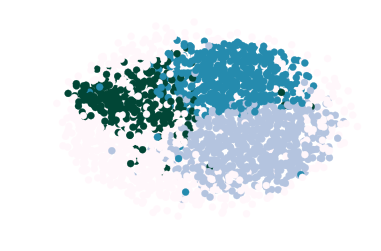

In [252]:
plt.scatter(pos[:,0], pos[:,1], c=labels, cmap=plt.cm.PuBuGn)
plt.axis('off')
plt.show()

<h2 class="section_header">Latent Dirichlet Allocation</h2>

LDA is a probabalistic topic model that assumes documents are a mixture of topics and each word in the document is atttributabe to the documents topics. This is useful because given 10 topics, a new topic can be assigned probabilities of being in each topic. By concatinating all the reviews for one business into a document we can then train this model to discover different types of businesses. This can be used to find similar reviews for a business or a businesses competitors by looking at the similarity of their topic distribution.

In [166]:
from gensim import corpora, models, similarities 
import pyLDAvis.gensim

In [180]:
#preprocess
tokenized_docs = [get_nouns(tokenize(x)) for x in review_list]

In [182]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [210]:
lda = models.LdaModel(corpus, num_topics=7, id2word=dictionary, 
                      update_every=5, chunksize=5, passes=6)

Ater looking at the words assosiated with the different topics I was able to label these groups.

In [234]:
topic_labels = [
    'Families and Groups',
    'Rooms and Physical Aspects',
    'Entertainment and Events',
    'Customer Service',
    'Pool and Casino',
    'Resturant at Water Show',
    'Transportation'
]

In [235]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (Families and Groups)
--------------------
i
everything
suite
kids
pool
family
part
conference
time
hotel
stay
life
river
room
mandalay
visit
husband
bay
call
party

Topic 1 (Rooms and Physical Aspects)
--------------------
room
bathroom
shower
floor
tv
bed
view
door
toilet
music
water
level
elevators
line
noise
hour
price
elevator
person
doors

Topic 2 (Entertainment and Events)
--------------------
show
people
table
business
ticket
work
reservations
nights
things
tickets
suite
bag
michael
jackson
wedding
problem
thank
years
venue
guy

Topic 3 (Customer Service)
--------------------
i
room
hotel
service
time
night
mandalay
desk
bay
front
valet
experience
customer
rooms
coffee
staff
morning
minutes
anything
manager

Topic 4 (Pool and Casino)
--------------------
pool
hotel
strip
mandalay
i
bay
rooms
casino
vegas
place
area
people
beach
check
resort
it's
hotels
pools
restaurants
time

Topic 5 (Resturant at Water Show)
--------------------
day
stay
line
days
fee
nothing
resort
h

In [212]:
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

These topics perform very well in finding the latentent structure of areas of the business. One issue with this model is it is difficult to find the appropriate number of clusters for a new business.

## LDA For Multiple Businesses

Next we apply LDA to reviews from 5 different types of businesses. The goal of this is to discover these labels.

In [270]:
# Connect to database
client = MongoClient()
db = client.yelp

In [413]:
# Get examples from distinct businesses for training
different_categories = ['automotive', 'hair salons', 'pets', 'medical centers', 'butcher']

category_dict = {}
for category in different_categories:
    cursor = db.businesses.find({'categories':{'$in':[category]}}).limit(100)
    total_reviews = []
    for business in cursor:
        biz_reviews = [x['text'] for x in get_business_reviews(business['business_id'])]
        concat_biz_review = ' '.join(biz_reviews)
        cleaned_review = get_nouns(tokenize(concat_biz_review))
        total_reviews.append(cleaned_review)
    category_dict[category] = total_reviews

In [414]:
#preprocess
tokenized_docs = []
category_labels = []
for i, category in enumerate(different_categories):
    tokenized_docs += category_dict[category]
    category_labels += [i] * len(category_dict[category])

In [433]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=.05, no_above=0.6)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [434]:
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, 
                      update_every=1, chunksize=100, passes=10)

In [435]:
lda.show_topics()

[(0,
  u'0.032*"bbq" + 0.029*"meat" + 0.027*"food" + 0.019*"brisket" + 0.016*"mac" + 0.016*"ribs" + 0.015*"pork" + 0.014*"beans" + 0.013*"vegas" + 0.013*"cheese"'),
 (1,
  u'0.025*"dog" + 0.016*"dogs" + 0.015*"staff" + 0.012*"store" + 0.012*"food" + 0.012*"service" + 0.011*"prices" + 0.008*"customer" + 0.007*"pet" + 0.007*"day"'),
 (2,
  u'0.019*"hospital" + 0.019*"staff" + 0.017*"care" + 0.014*"doctor" + 0.012*"room" + 0.011*"dr" + 0.010*"vet" + 0.009*"hours" + 0.008*"nurses" + 0.008*"office"'),
 (3,
  u'0.032*"car" + 0.017*"service" + 0.009*"work" + 0.007*"people" + 0.007*"insurance" + 0.007*"appointment" + 0.007*"minutes" + 0.007*"experience" + 0.006*"oil" + 0.006*"day"'),
 (4,
  u'0.062*"hair" + 0.027*"salon" + 0.021*"cut" + 0.014*"stylist" + 0.013*"haircut" + 0.012*"appointment" + 0.012*"color" + 0.010*"job" + 0.009*"years" + 0.009*"experience"')]

In [450]:
topic_labels = [
    'butcher',
    'pets',
    'medical centers',
    'automotive',
    'hair salons'
]

In [451]:
topics_matrix = lda.show_topics(formatted=False, num_words=10)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (butcher)
--------------------
bbq
meat
food
brisket
mac
ribs
pork
beans
vegas
cheese

Topic 1 (pets)
--------------------
dog
dogs
staff
store
food
service
prices
customer
pet
day

Topic 2 (medical centers)
--------------------
hospital
staff
care
doctor
room
dr
vet
hours
nurses
office

Topic 3 (automotive)
--------------------
car
service
work
people
insurance
appointment
minutes
experience
oil
day

Topic 4 (hair salons)
--------------------
hair
salon
cut
stylist
haircut
appointment
color
job
years
experience


Now that we have discovered these topics, given reviews for a business we can give the amount it belongs to each topic.

In [453]:
' '.join(all_reviews[0])

u"used to go there for tires brakes etc their prices have gone way up for mid-level tires for a toyota plus of the new tires went flat within weeks since they don t make appointments the wait to get the tire looked at was hours sorry--can't wait that long to get a warranted repair they lost my business for good"

In [454]:
lda[dictionary.doc2bow(all_reviews[0])]

[(0, 0.1250188690611381), (3, 0.74550391793766135), (4, 0.11561321254180351)]

In [449]:
accuracy = 0
for i, category in enumerate(different_categories):
    results = []
    num_category = len(category_dict[category])
    for review in category_dict[category]:
        doc_bow = dictionary.doc2bow(review)
        distribution = lda[doc_bow]
        percents = np.array([x[1] for x in distribution])
        max_indx = np.argmax(percents)
        results.append(distribution[max_indx][0])
    classes, amounts = np.unique(results, return_counts=True)
    print "Classes: %7s, Amount: %s" % (classes, amounts)

Classes: [1 2 3], Amount: [ 7  1 92]
Classes:     [4], Amount: [100]
Classes:   [1 2], Amount: [46 54]
Classes:   [2 3], Amount: [93  7]
Classes:   [0 3], Amount: [98  2]


<h1 class='main_header'>Sentiment Analysis</h1>
<hr>

Sentiment analysis is a branch of natural language processing that aims to systematically identify, extract, and quantify affective states and subjective information. The prototypical example is classifying if a review is positive or negative. For a bisunesses Yelp reviews we will use this so we can determine what is included in the most negative and most positive reviews. This can give concise information on what needs to be fixed and what is going well.

There are several teqniques for doing this...

<h2 class='section_header'>Naive Bayes</h2>

Because of the complex nature of working with text, historically the simple naive bayes model has been the standard for sentiment anaysis. The text is read in and then transformed into a simple bag of words. This gives the probability of words ocurring given a certain sentiment which is then used by naive bayes.

$$ P(c\vert x) = \frac{P(x\vert c)P(c)}{P(x)}$$
$$ P(c\vert x) = P(x_1\vert c) \times P(x_2\vert c)\times \dots P(x_n\vert c) \times P(c)$$

In [459]:
from yelp_utils.preprocess_reviews import prepare_classify
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [460]:
# Create trainging set of positive and negative examples
pos_list, neg_list = prepare_classify(700)
train = pos_list[:500] + neg_list[:500]
test = pos_list[500:] + neg_list[500:]

In [461]:
naiveBayes = NaiveBayesClassifier(train)

In [463]:
naiveBayes.show_informative_features()

Most Informative Features
         contains(Great) = True              pos : neg    =     32.3 : 1.0
      contains(terrible) = True              neg : pos    =     24.3 : 1.0
         contains(awful) = True              neg : pos    =     19.0 : 1.0
         contains(worst) = True              neg : pos    =     16.6 : 1.0
          contains(paid) = True              neg : pos    =     16.3 : 1.0
       contains(variety) = True              pos : neg    =     15.7 : 1.0
         contains(dirty) = True              neg : pos    =     15.0 : 1.0
        contains(pricey) = True              pos : neg    =     13.0 : 1.0
          contains(Rock) = True              pos : neg    =     11.8 : 1.0
         contains(liked) = True              pos : neg    =     11.7 : 1.0


In [467]:
naiveBayes.accuracy(test_set)

0.7375

<h1 class='main_header'>Automatic Summary</h1>
<hr>

In [469]:
from sumy.nlp import tokenizers
from sumy.parsers import plaintext
from sumy.summarizers import lex_rank

In [471]:
review_list = [x['text'] for x in get_business_reviews(BIZ_ID)]

In [480]:
concat_review = ' '.join(review_list[:100])

tokenizer = tokenizers.Tokenizer('english')    
parse = plaintext.PlaintextParser(concat_review, tokenizer)
doc = parse.document  
rank = lex_rank.LexRankSummarizer()

#Print the top ten results of the sorting
print('Ranked Sentences:')
print('------------------------------')
for i, sentence in enumerate(rank(doc, 10)):
    print('{}: {}'.format(i+1, sentence))
    print('\n')

Ranked Sentences:
------------------------------
1: I had a great time at Mandalay Bay!


2: The only negative I can come up with is that the hotel is located at the end of the Strip, so if you want to see something you will need to walk a lot.


3: It has it all.


4: It has it all.


5: it was great .


6: The pool at the Mandalay Bay is the best in Vegas.


7: The rooms are nice, not great but very good.


8: If you are all about hanging out by a pool, this is the hotel for you.


9: There's a bunch of good restaurants that you should try if you are staying there or not....Burger Bar which is in the Mandalay Bay Place is a must!


10: The only downfall on the Mandalay Bay is the location...it is located on the south strip...it's the last hotel on the south part of the strip so unless this is your first visit and you want to be more centralized so you can walk around and explore the strip, you might want to stay at this hotel during your return trips back.




In [21]:
%matplotlib inline

from yelp_utils.data_manager import get_all_reviews_by_user_for_city, get_average_lat_and_long, get_max_distacne_from_mid, get_radius_from_review_centers_dict
from pymongo import MongoClient
import matplotlib.pyplot as plt
import math
import numpy as np
import gpxpy.geo
from tqdm import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans
import json
from sklearn.cluster import KMeans

client = MongoClient()
db = client.yelp

In [6]:
def get_all_reviews_by_user_for_city(city):
    """A function which queries for all the reviews associated to all the buisnesses in a city
    returns a dict (biz_id : review_locations)"""
    bizes = list(db.businesses.find({"city": city}, { "business_id": 1, "latitude": 1, "longitude": 1, "categories": 1}))
    user_reviews = defaultdict(list)
    for biz in tqdm(bizes):
        biz_id = biz['business_id']
        rel_review = db.reviews.find({"business_id": biz_id})
        for review in list(rel_review):
            user_reviews[review['user_id']].append((biz["latitude"], biz["longitude"]))
    return user_reviews

In [7]:
henderson_reviews = get_all_reviews_by_user_for_city("Henderson")

100%|██████████| 3788/3788 [00:04<00:00, 928.81it/s]


In [9]:
#Manipulating Latitude and Longitude
def get_average_lat_and_long(set_lat_by_long):
    """We get some wierd outliers from the 'set_lat_by_long' we'll need to take care of these some how
    returns: the average latitude and longitude 
    NOTE: this is simply the average of the latitude and longitude values (not based on geodicics)"""
    set_lat_by_long = np.asarray(set_lat_by_long).copy()
    return np.average(set_lat_by_long, axis=0)

def get_max_distacne_from_mid(set_lat_by_long):
    """Because of the outliers (these are caused by a missing sign) get_average_lat_and_long returns a point 
    that is very far from the actual center"""
    set_lat_by_long = np.asarray(set_lat_by_long)
    mid = get_average_lat_and_long(set_lat_by_long)
    return np.max([gpxpy.geo.haversine_distance(mid[0], mid[1], lat, lon)/1609.34 for lat, lon in set_lat_by_long])


## Dealing with These Outliers

Sklearn provides some Outlier detection methods that are robust, such as <a href="http://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope">EllipticEnvelope</a> and <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest">IsolationForest</a>.

Before thinking to consult sklearn for methods concerning outlier detection I developed one (that will not generalize by any means) using K means. 

Bassically the idea is that no city is bigger than 100 Miles, so if any given distance from the center is over 100 miles split the clusters into two sperate clusters. 

### Providing examples of the problem
For this example we'll use "henderson_reviews" since its pretty small, and I know the city of Henderson very well, so I will be able to determine BS more so than I would for any other city. 

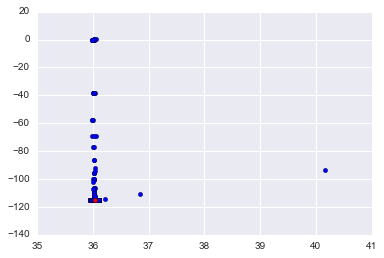

In [11]:
def get_all_centers_as_array(reviews_dict):
    x_centers_list = []
    y_centers_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        if len(user_review) == 1:
            continue #We don't care about single reviewers! They give us no information.
        x, y = get_average_lat_and_long(user_review)
        x_centers_list.append(x)
        y_centers_list.append(y)
        associated_id.append(uid)
    return np.array([x_centers_list, y_centers_list]).T, associated_id

def visualize_locations(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    centers = get_all_centers_as_array(reviews_dict)[0]
    plt.scatter(centers[:, 0], centers[:, 1])
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    return plt

def get_bad_point(reviews_dict, y_bad=-1):
    bad_points = None
    for uid, user_review in reviews_dict.iteritems():
        x, y = get_average_lat_and_long(user_review)
        if y > y_bad:
            bad_points = user_review
    return bad_points

bad_point = get_bad_point(henderson_reviews)
visualize_locations(henderson_reviews).show()

That red dot near the 36 tick is the actual location of Henderson. 36' N 0' E (toward the top of that line) is a location just north of Algeria. Over 5000 miles away! And that is the CENTER! (That means that one of the points is in Asia or something!) Henderson isn't quite that big, in fact henderson is contained completely between: (35.891588, -115.218488) and (36.130405, -114.914276)!

We have stored this center in Connecticut in the variable "bad_points" in order to further investigate the issue.
This is obviously an issue as some of the reviews radius will be over 2000 miles! Surely a bike shop in Henderson can't view a bike shop in Connecticut as a competitor! That is outrageous.

In [14]:
bad_point

[(36.019323, 115.086769), (35.9658025616, -115.169019763)]

### Naive K means Outlier Removal
This next approach, while Naive, emperically at least leaves a cluster which is far more reasonable. 

In [18]:
def get_clusters(data, n_clusters=2):
    kmeans = KMeans(n_clusters=2).fit(data)
    centers = kmeans.cluster_centers_
    to_return = [[] for i in range(len(centers))]
    for x in data:
        dist = np.linalg.norm(centers - x, 1, axis=1)
        index = np.argmin(dist)
        to_return[index].append(x)
    #Below we make the assumption that the most points are found in a given city at least!
    return sorted([np.vstack(i) for i in to_return], key=lambda x: len(x))[::-1]

In [19]:
def clean_reviewer_average_radius_with_get_clusters(reviews):
    good_points = {}
    for i, dict_pair in enumerate(reviews.iteritems()):
        key, val = dict_pair
        if len(val) > 1:
            dis_from_mid = get_max_distacne_from_mid(val)
            k = 2
            while dis_from_mid > 100: #cities are never bigger than 100 miles in diameter
                val = get_clusters(val, n_clusters=k)[0] #select the data with the most points
                k += 1
                dis_from_mid = get_max_distacne_from_mid(val)
            good_points[key] = val
    return good_points

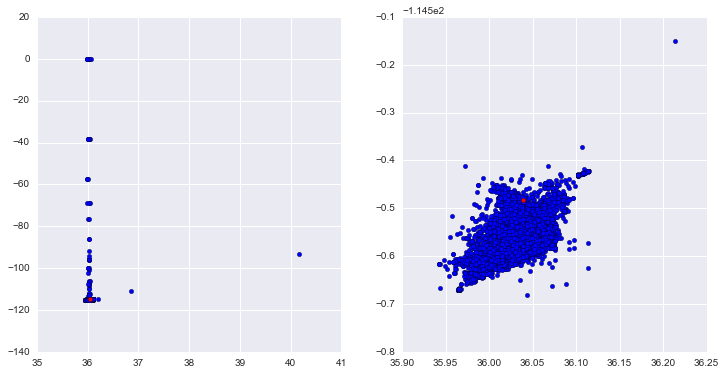

In [32]:
kmeans_cleaned = clean_reviewer_average_radius_with_get_clusters(henderson_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
visualize_locations(henderson_reviews)

plt.subplot(1, 2, 2)
visualize_locations(kmeans_cleaned).show()

### EllipticEnvelope

A indepth tutorial for this method (which was used to apply to this data) can be found at: <a href="http://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html#sphx-glr-auto-examples-applications-plot-outlier-detection-housing-py"> scikits website </a>

#### Visualizing the boundry
In order to quickly determine how useful the EllipticEnvelope method might be useful I visualize it below.

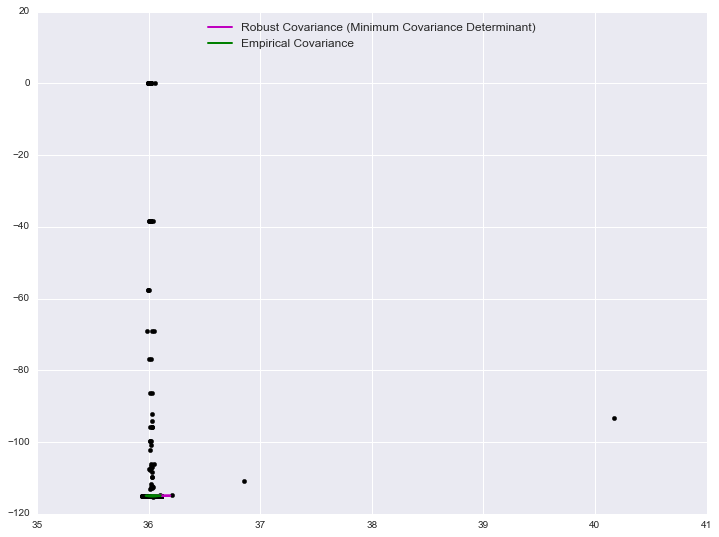

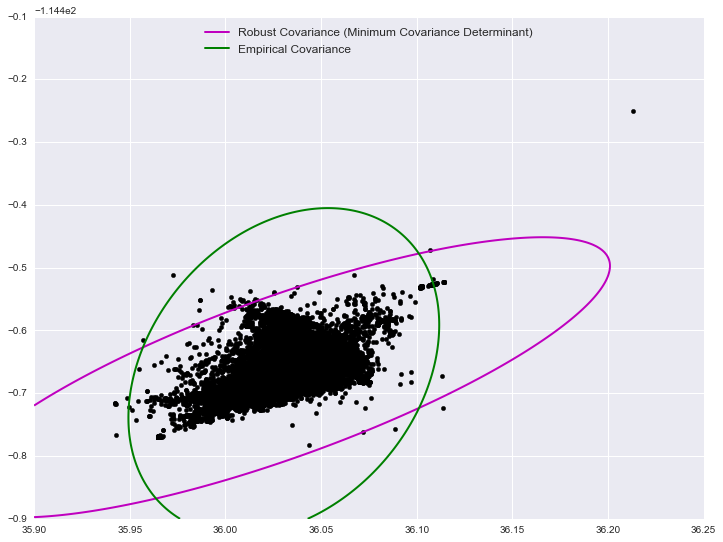

In [25]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.datasets import load_boston

# Get data
X1 = get_all_centers_as_array(henderson_reviews)[0]  # two clusters

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1.,
                                             contamination=0.005),
    "Robust Covariance (Minimum Covariance Determinant)":
    EllipticEnvelope(contamination=0.005)}
colors = ['m', 'g', 'b']
legend1 = {}

# Learn a frontier for outlier detection with several classifiers
for xx, yy in [((35, 41), (-120, 20)), ((35.90, 36.25), (-114.5, -115.3))]:
    plt.figure(figsize=(12, 9))
    xx1, yy1 = np.meshgrid(np.linspace(xx[0], xx[1], 250), np.linspace(yy[0], yy[1], 250))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        plt.figure(1)
        clf.fit(X1)
        Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
        Z1 = Z1.reshape(xx1.shape)
        legend1[clf_name] = plt.contour(
            xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])

    legend1_values_list = list(legend1.values())
    legend1_keys_list = list(legend1.keys())

    # Plot the results (= shape of the data points cloud)
    #plt.title("Outlier detection on a real data set (boston housing)")
    plt.scatter(X1[:, 0], X1[:, 1], color='black')

    plt.xlim((xx1.min(), xx1.max()))
    plt.ylim((yy1.min(), yy1.max()))
    plt.legend((legend1_values_list[0].collections[0],
                legend1_values_list[1].collections[0]),
               (legend1_keys_list[0], legend1_keys_list[1]),
               loc="upper center",
               prop=matplotlib.font_manager.FontProperties(size=12))

    plt.show()

SKlearn suggests using the default value for the `support_fraction` parameter, so we will (this gives the purple boundry)

This method seems to work very well! However I don't totally understand how it is working, so I read (and suggest reading) http://www.geo.upm.es/postgrado/CarlosLopez/papers/FastAlgMCD99.pdf

The algorithm used is NOT an EM algorithm, but rather a MM algorithm (Majorize-Minimization). To read more specifics about it's innner workings also check out: https://wis.kuleuven.be/stat/robust/papers/2010/wire-mcd.pdf

In [26]:
def clean_reviewer_average_radius_with_EllipticEnvelope(reviews):
    good_points = {}
    classifier = EllipticEnvelope(contamination=0.005)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    inlier_indexes = np.where(classifier.predict(centers) != -1)
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

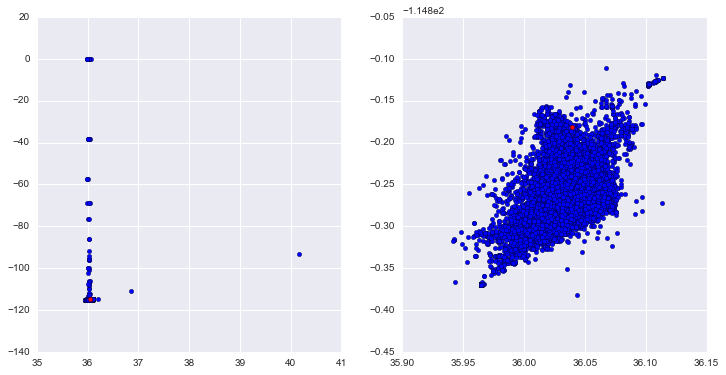

In [34]:
EllipticEnvelope_cleaned = clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
visualize_locations(henderson_reviews)

plt.subplot(1, 2, 2)
visualize_locations(EllipticEnvelope_cleaned).show()

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more than emperical, there is some hard mathematics that has been developed regarding the statistics behind this method


### Random Forest for Anomaly Detection (Isolation Forest)

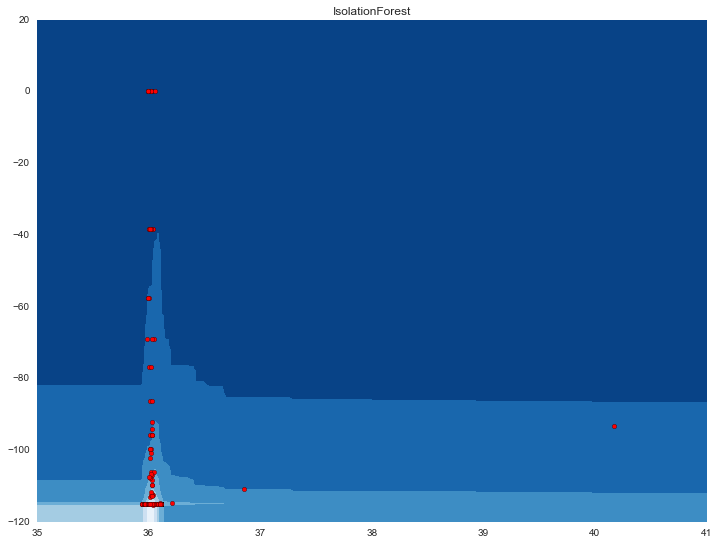

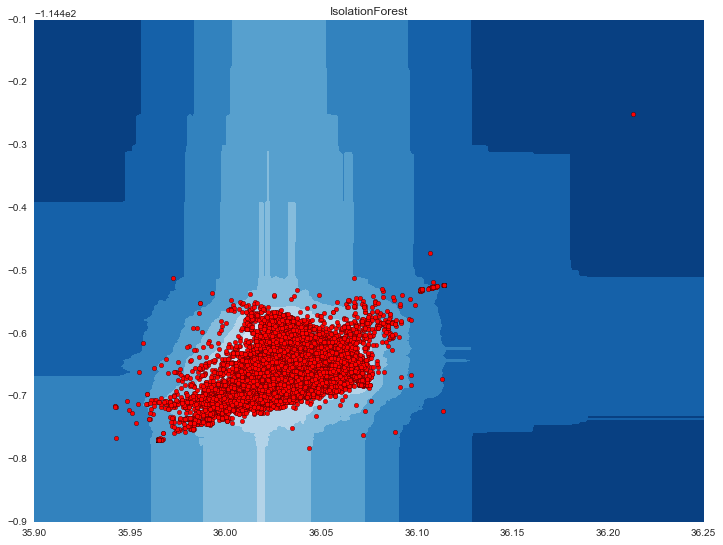

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

plt.figure(figsize=(12, 9))
rng = np.random.RandomState(42)

# Generate train data
X = get_all_centers_as_array(henderson_reviews)[0]

# fit the model
clf = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
clf.fit(X)

for xx_t, yy_t in [((35, 41), (-120, 20)), ((35.90, 36.25), (-114.5, -115.3))]:
    plt.figure(figsize=(12, 9))
    xx, yy = np.meshgrid(np.linspace(xx_t[0], xx_t[1], 250), np.linspace(yy_t[0], yy_t[1], 250))
    # plot the line, the samples, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    c = plt.scatter(X[:, 0], X[:, 1], c='red')
    plt.axis('tight')
    plt.xlim((xx.min(), xx.max()))
    plt.ylim((yy.min(), yy.max()))
    plt.show()

In [36]:
from sklearn.ensemble import IsolationForest
def clean_reviewer_average_radius_with_IsolationForest(reviews):
    rng = np.random.RandomState(42)
    good_points = {}
    classifier = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    des_on = classifier.decision_function(centers)
    #Within four standard deviations of the decision_function
    inlier_indexes = np.where(abs(des_on - np.mean(des_on))  < 4*np.std(des_on))
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

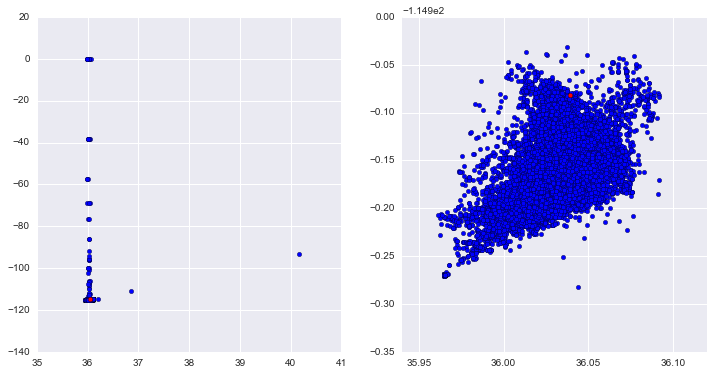

In [37]:
IsolationForest_cleaned = clean_reviewer_average_radius_with_IsolationForest(henderson_reviews)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
visualize_locations(henderson_reviews)

plt.subplot(1, 2, 2)
visualize_locations(IsolationForest_cleaned).show()

#### Benefits to this model 

1) If a city is over 100 miles in diameter this model will continue to work

2) It's more very fast and parrellization comes for free with it, unlike with the EllipticEnvelope.

### Competitive Region Results
All of the methods produce pretty similar radi:

In [38]:
print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(kmeans_cleaned)))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(EllipticEnvelope_cleaned)))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(IsolationForest_cleaned)))

Naive K-Means Clusters predicted a radius of: 4.4297
Elliptic Envelope predicted a radius of: 4.3851
Isolation Forest predicted a radius of: 4.3944


### Phoenix
For sanity that all of our learners are working properly and as expected we will now test it on a new set to make sure we are still getting reasonable results. 

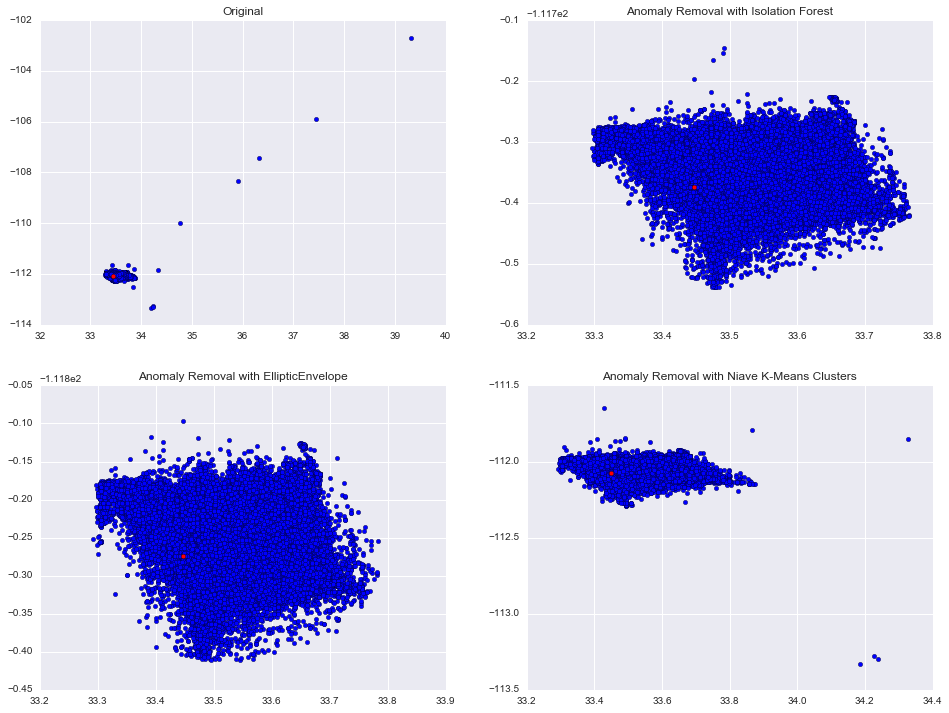

Naive K-Means Clusters predicted a radius of: 8.9329
Elliptic Envelope predicted a radius of: 8.9421
Isolation Forest predicted a radius of: 8.9380


In [39]:
phoenix_reviews = get_all_reviews_by_user_for_city("Phoenix")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
visualize_locations(phoenix_reviews, (33.448, -112.074)).title("Original")
plt.subplot(2, 2, 2)
visualize_locations(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Isolation Forest")
plt.subplot(2, 2, 3)
visualize_locations(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with EllipticEnvelope")
plt.subplot(2, 2, 4)
visualize_locations(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Niave K-Means Clusters")

plt.show()

print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews))))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews))))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews))))